In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotion-ai/Emotion AI Dataset/weights.hdf5
/kaggle/input/emotion-ai/Emotion AI Dataset/weights_emotions.hdf5
/kaggle/input/emotion-ai/Emotion AI Dataset/icml_face_data.csv
/kaggle/input/emotion-ai/Emotion AI Dataset/emotion.json
/kaggle/input/emotion-ai/Emotion AI Dataset/weights_emotion.hdf5
/kaggle/input/emotion-ai/Emotion AI Dataset/detection.json
/kaggle/input/emotion-ai/Emotion AI Dataset/weights.h5
/kaggle/input/emotion-ai/Emotion AI Dataset/facial_detection.ipynb
/kaggle/input/emotion-ai/Emotion AI Dataset/server.log
/kaggle/input/emotion-ai/Emotion AI Dataset/models.config
/kaggle/input/emotion-ai/Emotion AI Dataset/training.csv
/kaggle/input/emotion-ai/Emotion AI Dataset/test.csv
/kaggle/input/emotion-ai/Emotion AI Dataset/data.csv
/kaggle/input/emotion-ai/Emotion AI Dataset/augmented.csv
/kaggle/input/emotion-ai/Emotion AI Dataset/face_detection.json
/kaggle/input/emotion-ai/Emotion AI Dataset/weights_keypoint.hdf5


In [3]:
# Import necessary packages
import pandas as pd
import numpy as np
import os
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from PIL import *
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt

In [4]:
# Load the facial Key points Data
keyfacial_df=pd.read_csv("/kaggle/input/emotion-ai/Emotion AI Dataset/data.csv")

In [5]:
keyfacial_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [6]:
# obtain the Relavent information about the data frame
keyfacial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [7]:
# Check if any Null value exists on the Dataframe
keyfacial_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [8]:
keyfacial_df["Image"].shape

(2140,)

In [9]:
# Since values for the image are given as space separated string, separate the values using ' ' as separator.
# Then convert this into numpy array using np.fromstring and convert the obtained 1D array into 2D array of shape (96, 96)
keyfacial_df["Image"]=keyfacial_df["Image"].apply(lambda x: np.fromstring(x,dtype=int,sep=" ").reshape(96,96))

In [10]:
# Obtain the shape of the Image
keyfacial_df["Image"][0].shape

(96, 96)

In [11]:
#Obtain the average, minimum and maximum values for 'right_eye_center_x'
maax=keyfacial_df['right_eye_center_x'].max()
miin=keyfacial_df['right_eye_center_x'].min()
avg=keyfacial_df['right_eye_center_x'].mean()
print(f"Max = {maax} Min= {miin} Average = {avg}")

Max = 42.495171727 Min= 18.9226106286 Average = 29.64026856456148


# **Visualize The Images**

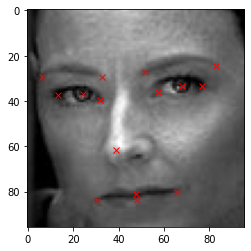

In [12]:
# Plot a random image from the dataset along with facial keypoints.
# Image data is obtained from df['Image'] and plotted using plt.imshow
# 15 x and y coordinates for the corresponding image 
# since x-coordinates are in even columns like 0,2,4,.. and y-coordinates are in odd columns like 1,3,5,..
# we access their value using .loc command, which get the values for coordinates of the image based on the column it is refering to.
i=np.random.randint(1,len(keyfacial_df))

plt.imshow(keyfacial_df["Image"][i],cmap='gray')
for j in range(1,31,2):
    plt.plot(keyfacial_df.loc[i][j-1],keyfacial_df.loc[i][j],'rx')

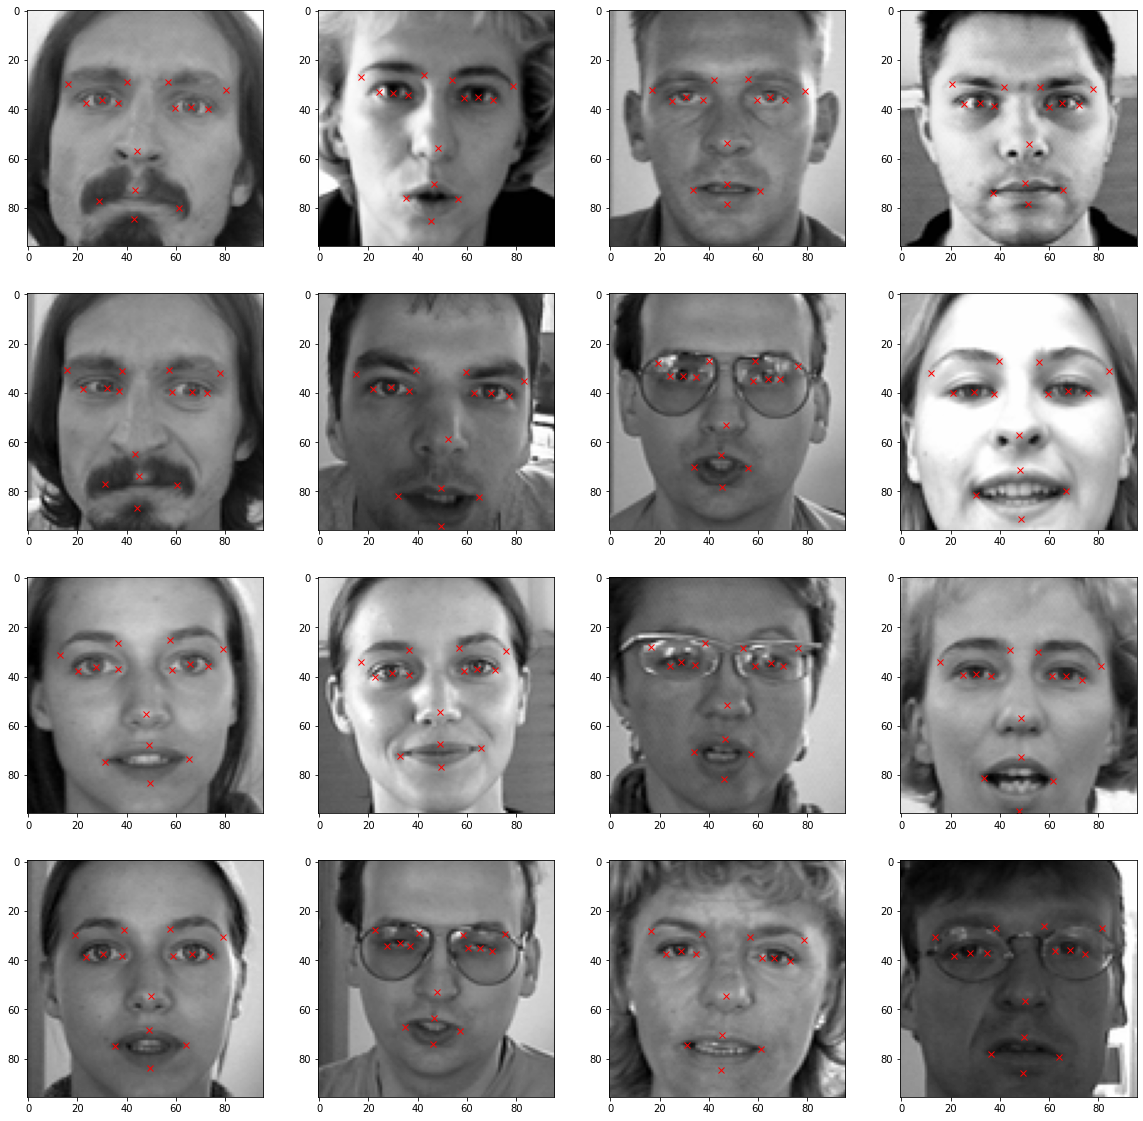

In [13]:
# Let view More Image in a Grid
fig=plt.figure(figsize=(20,20))

for i in range(16):
    ax=fig.add_subplot(4,4,i+1)
    image=plt.imshow(keyfacial_df["Image"][i],cmap='gray')
    for j in range(1,31,2):
        plt.plot(keyfacial_df.loc[i][j-1],keyfacial_df.loc[i][j],'rx')

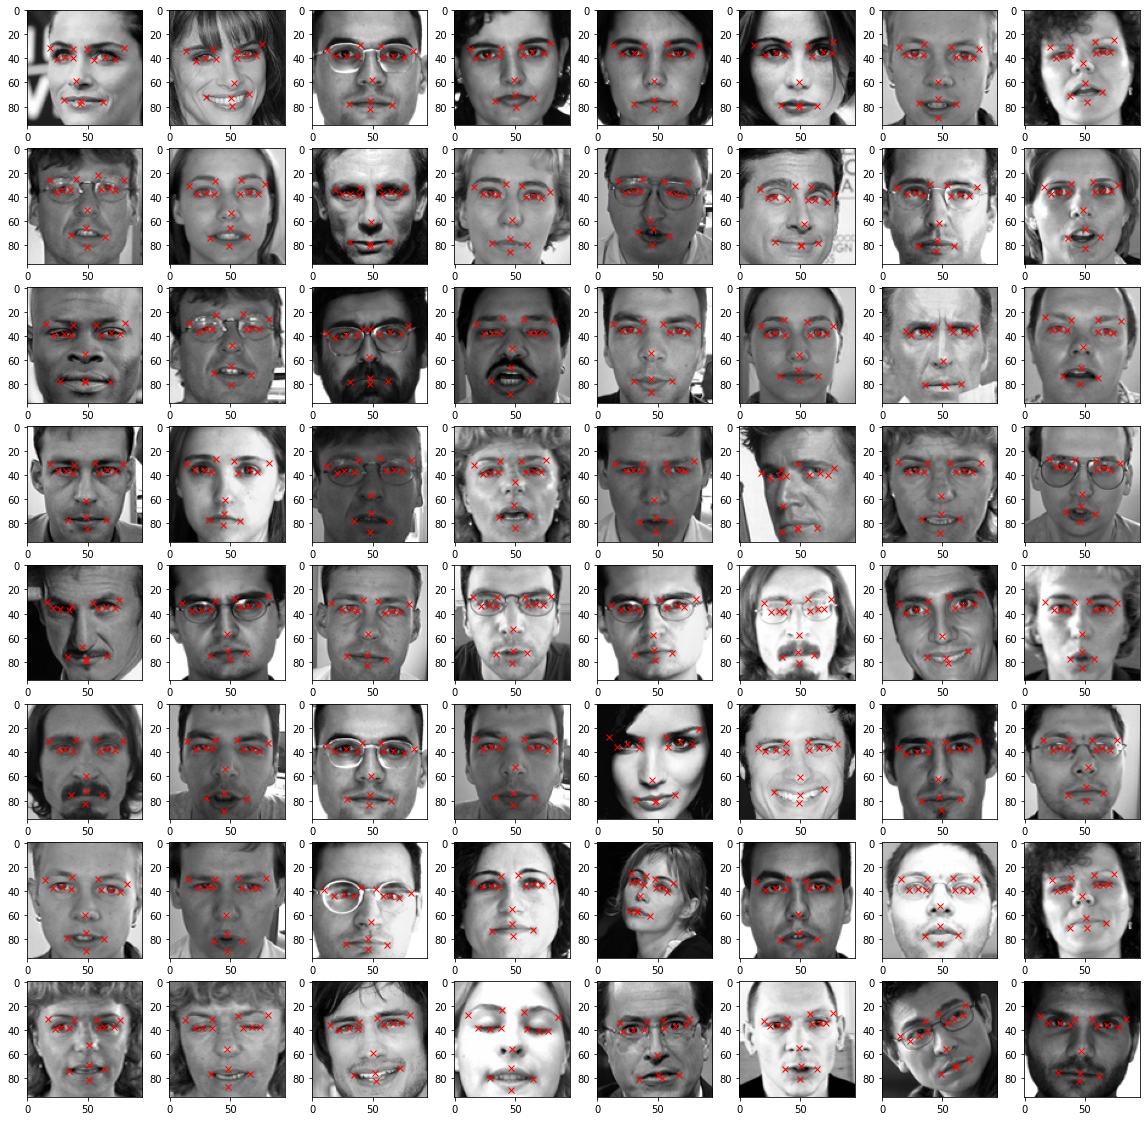

In [14]:
#Perform a sanity check on the data by randomly visualizing 64 new images along with their cooresponding key points
fig=plt.figure(figsize=(20,20))
for i in range(64):
    k=np.random.randint(1,len(keyfacial_df))
    ax=fig.add_subplot(8,8,i+1)
    image=plt.imshow(keyfacial_df["Image"][k],cmap='gray')
    for j in range(1,31,2):
        plt.plot(keyfacial_df.loc[k][j-1],keyfacial_df.loc[k][j],'rx')

# ** Perform Image Augmentation **

In [15]:
# Create a new copy of the DataFrame
import copy
keyfacial_df_copy=copy.copy(keyfacial_df)

In [16]:
# Obtain Columns in dataframe
columns=keyfacial_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [17]:
# Horizontal Flip - flip the Images along y axis
keyfacial_df_copy["Image"]=keyfacial_df_copy["Image"].apply(lambda x : np.flip(x,axis=1))

# since we are flipping horizontally, y coordinate values would be the same
# Only x coordiante values would change, all we have to do is to subtract our initial x-coordinate values from width of the image(96)
for i in range(len(columns)):
    if i%2==0:
        keyfacial_df_copy[columns[i]]=keyfacial_df_copy[columns[i]].apply(lambda x:96. - float(x))


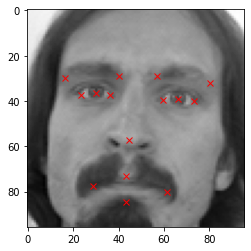

In [18]:
# Show The Original Image
plt.imshow(keyfacial_df["Image"][0],cmap='gray')
for j in range(1,31,2):
    plt.plot(keyfacial_df.loc[0][j-1],keyfacial_df.loc[0][j],'rx')

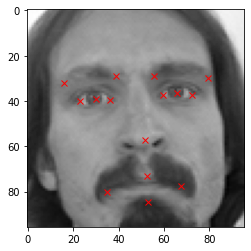

In [19]:
# Show the Horizontally Flipped Image
plt.imshow(keyfacial_df_copy["Image"][0],cmap="gray")
for j in range(1,31,2):
    plt.plot(keyfacial_df_copy.loc[0][j-1],keyfacial_df_copy.loc[0][j],'rx')

In [20]:
# Concatenate the original dataframe with the augmented dataframe
augmented_df=np.concatenate((keyfacial_df,keyfacial_df_copy))

In [21]:
augmented_df.shape

(4280, 31)

In [22]:
# Randomingly increasing the brightness of the images
# We multiply pixel values by random values between 1.5 and 2 to increase the brightness of the image
# we clip the value between 0 and 255
import random
keyfacial_df_copy=copy.copy(keyfacial_df)
keyfacial_df_copy["Image"]=keyfacial_df_copy["Image"].apply(lambda x : np.clip(random.uniform(1.5,2)*x,0.0,255.0))
augmented_df=np.concatenate((augmented_df,keyfacial_df_copy))
augmented_df.shape

(6420, 31)

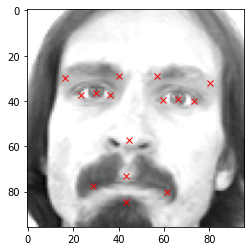

In [23]:
# show Image with Increased Brightness
plt.imshow(keyfacial_df_copy["Image"][0],cmap='gray')
for j in range(1,31,2):
    plt.plot(keyfacial_df_copy.loc[0][j-1],keyfacial_df_copy.loc[0][j],'rx')

#### Augment images by flipping them vertically (Hint: Flip along x-axis and note that if we are flipping along x-axis, x co-ordinates won't change)

In [24]:
keyfacial_df_copy=copy.copy(keyfacial_df)
# Vertical flip along x axis
keyfacial_df_copy["Image"]=keyfacial_df_copy["Image"].apply(lambda x : np.flip(x,axis=0))
# since we are flipping vertically, x coordinate values would be the same
# Only y coordiante values would change, all we have to do is to subtract our initial y-coordinate values from height of the image(96)
for j in range(len(columns)):
    if(j%2!=0):
        keyfacial_df_copy[columns[j]]=keyfacial_df_copy[columns[j]].apply(lambda x : 96.- float(x))
        
        


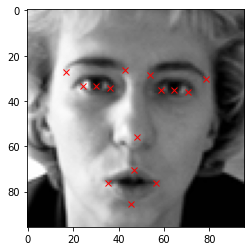

In [25]:
# show the Original Image
plt.imshow(keyfacial_df["Image"][1],cmap='gray')
for j in range(1,31,2):
    plt.plot(keyfacial_df.loc[1][j-1],keyfacial_df.loc[1][j],'rx')

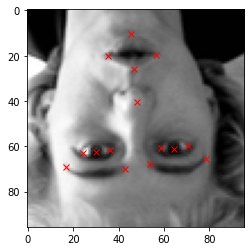

In [26]:
# Now see the vertically flipped Image
plt.imshow(keyfacial_df_copy["Image"][1],cmap='gray')
for j in range(1,31,2):
    plt.plot(keyfacial_df_copy.loc[1][j-1],keyfacial_df_copy.loc[1][j],'rx')

# **Perform Data Normalization And Data Preparation**

In [27]:
# Obtain the value of images which is present in the 31st column (since index start from 0, we refer to 31st column by 30)
img=augmented_df[:,-1]

# Normalize the Image
img=img/255.

# Create an empty array of shape (x, 96, 96, 1) to feed the model
X=np.empty((len(img),96,96,1))

# Iterate through the img list and add image values to the empty array after expanding it's dimension from (96, 96) to (96, 96, 1)
for i in range(len(img)):
    X[i,]=np.expand_dims(img[i],axis=2)
    
# Convert the Array type to float32
X=np.asarray(X).astype(np.float32)
X.shape

(6420, 96, 96, 1)

In [28]:
# Obtain the value of x & y coordinates which are to used as target.
y=augmented_df[:,:30]
y=np.asarray(y).astype(np.float32)
y.shape

(6420, 30)

In [29]:
# Split the data into train and test data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [30]:
print(X_train.shape)
print(y_train.shape)

(5136, 96, 96, 1)
(5136, 30)


In [31]:
print(X_test.shape)
print(y_test.shape)

(1284, 96, 96, 1)
(1284, 30)


# **BUILD DEEP RESIDUAL NEURAL NETWORK KEY FACIAL POINTS DETECTION MODEL**

In [35]:
def res_block(X,filter,stage):
    # convolutional Block
    X_copy=X
    f1,f2,f3=filter
    
    # Main Path
    X=Conv2D(f1,(1,1),strides=(1,1),name='res_'+str(stage)+'_conv_a',kernel_initializer=glorot_uniform(seed=0))(X)
    X=MaxPool2D((2,2))(X)
    X=BatchNormalization(axis=3,name='bn_'+str(stage)+'_conv_a')(X)
    X=Activation('relu')(X)
    
    X=Conv2D(f2,(1,1),strides=(1,1), padding='same',name='res_'+str(stage)+'_conv_b',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name='bn_'+str(stage)+'_conv_b')(X)
    X=Activation('relu')(X)
    
    X=Conv2D(f3,kernel_size=(1,1),strides=(1,1),name='res_'+str(stage)+'_conv_c',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name='bn_'+str(stage)+'_conv_c')(X)
    
    
    # short Path
    X_copy=Conv2D(f3,kernel_size=(1,1),strides=(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
    X_copy=MaxPool2D((2,2))(X_copy)
    X_copy=BatchNormalization(axis=3,name = 'bn_'+str(stage)+'_conv_copy')(X_copy)
    
    # Add
    X=Add()([X,X_copy])
    X=Activation('relu')(X)
    
    # Identity Block 1
    X_copy = X


    # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

    # ADD
    X = Add()([X,X_copy])
    X = Activation('relu')(X)
    
    # Identity Block 2
    X_copy=X
    
    # Identity Block 2
    X_copy = X


    # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

    # ADD
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    return X
    


In [36]:
input_shape=(96,96,1)

# Input Tensor shape
X_input=Input(input_shape)

# Zero Padding
X=ZeroPadding2D((3,3))(X_input)

# 1- stage
X=Conv2D(64,(7,7),strides=(2,2),name='conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - stage
X=res_block(X,filter=[64,64,256],stage=2)

# 3 - stage
X = res_block(X, filter= [128,128,512], stage= 3)

# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)

model_1_facialKeyPoints=Model(inputs=X_input,outputs=X)
model_1_facialKeyPoints.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 102, 102, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________

# **COMPILE AND TRAIN KEY FACIAL POINTS DETECTION DEEP LEARNING MODEL**

In [37]:
adam=tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999,amsgrad=False)
model_1_facialKeyPoints.compile(loss="mean_squared_error",optimizer=adam,metrics=['accuracy'])


In [38]:
# save the best model with least validation loss
checkpointer=ModelCheckpoint(filepath="FacialKeyPoints_weights.hdf5",verbose=1,save_best_only=True)

In [41]:
history=model_1_facialKeyPoints.fit(X_train,y_train,batch_size=32,epochs=2,validation_split=0.05,callbacks=[checkpointer])

Epoch 1/2
153/153 [==============================] - 65s 422ms/step - loss: 77.8917 - accuracy: 0.5999 - val_loss: 227.9827 - val_accuracy: 0.6770

Epoch 00001: val_loss improved from 359.85410 to 227.98270, saving model to FacialKeyPoints_weights.hdf5
Epoch 2/2
153/153 [==============================] - 64s 418ms/step - loss: 54.7748 - accuracy: 0.5761 - val_loss: 101.8566 - val_accuracy: 0.6732

Epoch 00002: val_loss improved from 227.98270 to 101.85658, saving model to FacialKeyPoints_weights.hdf5
